In [1]:
from dapnn.imports import *
from dapnn.data_processing import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

import warnings
warnings.filterwarnings(action='once')

In [2]:
# Set the random seed for reproducible results
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything()

In [3]:
log_name='pdc_2020_0101100'
log = import_log(f'data/csv/PDC2020_training/{log_name}.csv.gz')
log.head(5)

,activity,trace_id,event_id
trace_id,,,
trace 1,###start###,trace 1,0
trace 1,t31,trace 1,1
trace 1,t41,trace 1,2
trace 1,t26,trace 1,3
trace 1,t36,trace 1,4


Making the train log into the format for LogBERT

In [75]:
# TODO: MAKE THIS THE FORMAT I WANT!

def mapping(log):
    """map log activities to numbers, TODO: maybe remove start and end?"""

    # get unique activities
    activities = log['activity'].unique()
    # sort them
    activities.sort()
    # create a dictionary of activities and numbers
    mapping = dict(zip(activities, range(len(activities))))

    # map activities to numbers
    log['activity'] = log['activity'].map(mapping)

    return log, mapping
    
def groupTraces(log):
    """group traces by trace id and keep the order of the events
    returns a df of lists of events"""
    
    grouped = log.set_index('trace_id').groupby('trace_id', as_index=False)['activity'].apply(list)
    grouped['activity'] = grouped['activity'].apply(lambda x: [i for i in x])
    return grouped

log, train_mapper = mapping(log)
log.head(5)

,activity,trace_id,event_id
trace_id,,,
trace 1,1,trace 1,0
trace 1,6,trace 1,1
trace 1,12,trace 1,2
trace 1,5,trace 1,3
trace 1,11,trace 1,4


In [41]:
grouped = groupTraces(log)
grouped

,activity
0,"[1, 6, 12, 5, 11, 13, 15, 8, 3, 20, 25, 2, 24, 7, 19, 12, 8, 3, 2, 7, 9, 12, 14, 17, 22, 4, 5, 13, 15, 20, 0]"
1,"[1, 7, 5, 10, 12, 14, 17, 22, 23, 13, 18, 15, 21, 25, 24, 14, 19, 9, 17, 22, 4, 5, 10, 13, 9, 4, 5, 10, 13, 9, 4, 5, 10, 13, 15, 20, 0]"
2,"[1, 2, 5, 11, 6, 13, 15, 12, 21, 8, 25, 3, 6, 12, 14, 17, 22, 23, 18, 14, 16, 22, 23, 18, 14, 22, 0]"
3,"[1, 5, 2, 10, 7, 13, 12, 9, 4, 5, 13, 9, 8, 3, 4, 5, 10, 6, 12, 13, 14, 9, 16, 4, 5, 11, 22, 13, 15, 23, 18, 20, 25, 14, 22, 23, 18, 14, 17, 22, 0]"
4,"[1, 2, 5, 13, 15, 6, 21, 25, 12, 8, 3, 2, 6, 12, 14, 17, 22, 0]"
...,...
995,"[1, 2, 5, 13, 7, 12, 15, 14, 16, 21, 24, 22, 19, 15, 20, 25, 24, 19, 9, 4, 5, 10, 13, 15, 20, 25, 24, 19, 9, 4, 5, 10, 13, 15, 21, 25, 0]"
996,"[1, 2, 6, 5, 10, 13, 9, 4, 5, 10, 12, 13, 14, 17, 22, 15, 21, 25, 0]"
997,"[1, 2, 6, 12, 5, 13, 15, 21, 14, 24, 17, 19, 22, 23, 15, 18, 20, 24, 14, 17, 19, 22, 9, 4, 5, 13, 9, 4, 5, 10, 13, 15, 21, 25, 24, 19, 15, 21, 25, 0]"
998,"[1, 5, 7, 12, 11, 14, 17, 22, 23, 13, 9, 18, 4, 14, 17, 5, 11, 13, 15, 21, 25, 22, 0]"


In [62]:
def df_to_file(df, file_name):
    with open(file_name, 'w') as f:
        for _, row in df.iterrows():
            line = ' '.join(map(str, row['activity']))
            f.write(line + '\n')
        
df_to_file(grouped, f'romdata/train')

In [ ]:
log, train_mapper = mapping(log)
grouped = groupTraces(log)
df_to_file(grouped, f'romdata/train')

finished making dataset for logbert

In [4]:
def training_dl(log,cat_names='activity',seed=45,ws=5,bs=32):
    categorify=Categorify()
    o=PPObj(log,procs=categorify,cat_names=cat_names,y_names=cat_names,splits=split_traces(log,test_seed=seed,validation_seed=seed))
    dls=o.get_dls(windows=partial(windows_fast,ws=ws),bs=bs)
    return o,dls,categorify

In [5]:
class ControlFlowModel(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(np.sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        
        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)

    def forward(self, xcat):
        xcat=xcat[:,0]
        x_act=xcat
        x_act = self.emb_act(x_act)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        return x_act

In [6]:
class HideOutput:
    'A utility function that hides all outputs in a context'
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def training_loop(learn,epoch,print_output,lr_find,fixed_learning_rate=0.01):
    '''
    Basic training loop that uses learning rate finder and one cycle training. 
    See fastai docs for more information
    '''
    if lr_find:
        lr=np.median([learn.lr_find(show_plot=print_output)[0] for i in range(5)])
        learn.fit_one_cycle(epoch,float(lr))
    else: learn.fit(epoch,fixed_learning_rate)


def train_validate(dls,m,metrics=accuracy,loss=F.cross_entropy,epoch=20,print_output=True,model_dir=".",lr_find=True,
                   patience=5,min_delta=0.005,show_plot=True,store_path='tmp',model_name='.model'):
    '''
    Trains a model on the training set with early stopping based on the validation loss.
    Afterwards, applies it to the test set.
    '''
    cbs = [
      EarlyStoppingCallback(monitor='valid_loss',min_delta=min_delta, patience=patience),
      SaveModelCallback(fname=model_name),
      ]
    learn=Learner(dls, m, path=store_path, model_dir=model_dir, loss_func=loss ,metrics=metrics,cbs=cbs)

    if print_output:
        training_loop(learn,epoch,show_plot,lr_find=lr_find)
        return learn.validate(dl=dls[2])
    else:
        with HideOutput(),learn.no_bar(),learn.no_logging():
            training_loop(learn,epoch,show_plot,lr_find=lr_find)
            return learn.validate(dl=dls[2])

In [7]:
squeeze_cross_entropy = lambda x,y:F.cross_entropy(x,y[0])
squeeze_accuracy =lambda x,y:accuracy(x,y[0])

/lv_local/home/romh/DAPNN/dapnn/dapnn/data_processing.py:187: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(c):


epoch,train_loss,valid_loss,,time
0,2.413128,2.278047,0.319668,00:04
1,1.499290,1.443896,0.483651,00:04
2,1.235800,1.208556,0.505612,00:04
3,1.136848,1.119968,0.516837,00:04
4,1.121764,1.101832,0.491459,00:04
5,1.072737,1.066697,0.493899,00:04
6,1.076607,1.064842,0.495852,00:04
7,1.051705,1.044510,0.526110,00:04
8,1.058386,1.042000,0.507565,00:04
9,1.039980,1.061169,0.514397,00:04


Better model found at epoch 0 with valid_loss value: 2.2780470848083496.
Better model found at epoch 1 with valid_loss value: 1.443895936012268.
Better model found at epoch 2 with valid_loss value: 1.2085555791854858.
Better model found at epoch 3 with valid_loss value: 1.1199676990509033.
Better model found at epoch 4 with valid_loss value: 1.1018322706222534.
Better model found at epoch 5 with valid_loss value: 1.0666967630386353.
Better model found at epoch 6 with valid_loss value: 1.064841866493225.
Better model found at epoch 7 with valid_loss value: 1.044510006904602.
Better model found at epoch 8 with valid_loss value: 1.0419998168945312.
Better model found at epoch 10 with valid_loss value: 1.025538444519043.
Better model found at epoch 11 with valid_loss value: 1.0117231607437134.
No improvement since epoch 11: early stopping


Better model found at epoch 0 with valid_loss value: 0.5048841238021851.


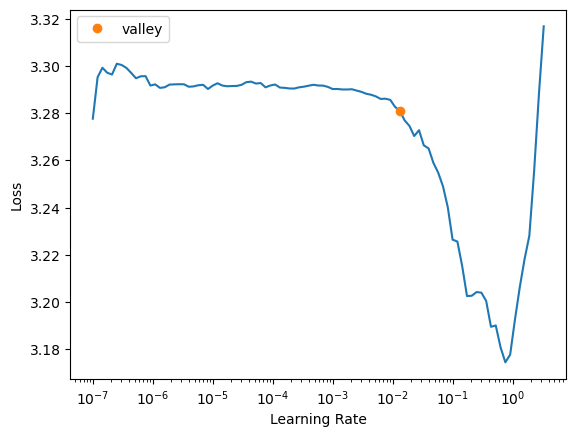

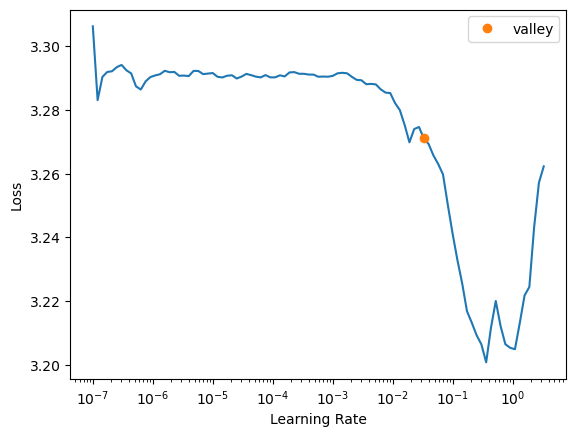

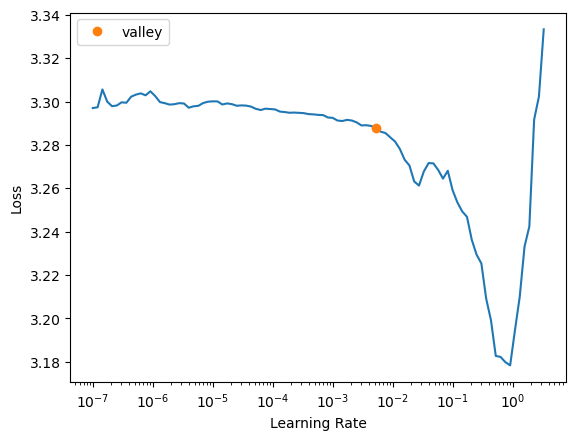

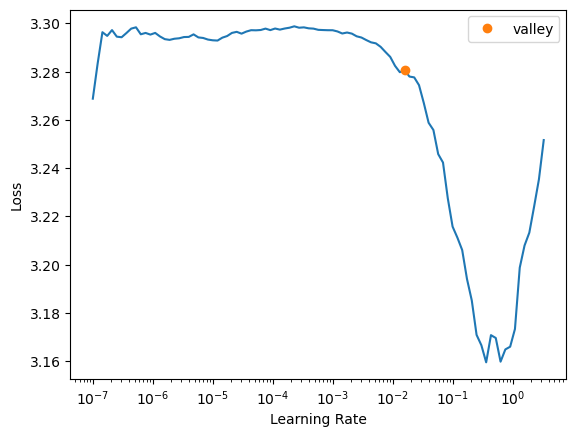

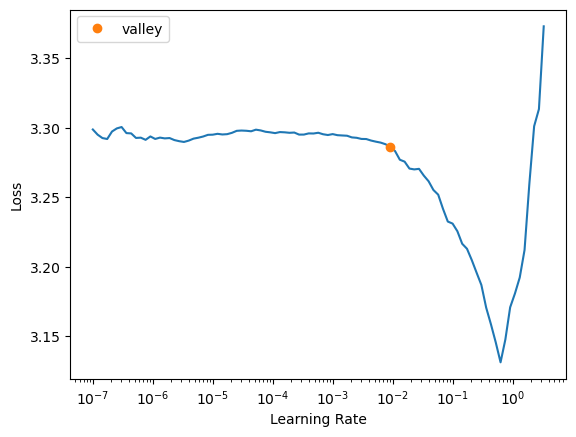

In [8]:
o,dls,categorify = training_dl(log)
m = ControlFlowModel(o)
train_val = train_validate(dls,m,epoch=25,metrics=squeeze_accuracy,loss=squeeze_cross_entropy)

In [9]:
test_log = import_log(f'data/csv/PDC2020_ground_truth/{log_name}.csv.gz')
test_log[test_log['normal'] == False].head(5)

,activity,trace_id,case:pdc:costs,normal,event_id
trace_id,,,,,
trace 4,###start###,trace 4,5.0,False,0
trace 4,t26,trace 4,5.0,False,1
trace 4,t32,trace 4,5.0,False,2
trace 4,t41,trace 4,5.0,False,3
trace 4,t44,trace 4,5.0,False,4


Making the test log into the format for LogBERT

In [76]:
abnormal = test_log[test_log['normal'] == False].copy()
normal = test_log[test_log['normal'] == True].copy()

abnormal['activity'] = abnormal['activity'].map(train_mapper)
normal['activity'] = normal['activity'].map(train_mapper)

print(normal)

abnormal_grouped = groupTraces(abnormal)
normal_grouped = groupTraces(normal)

df_to_file(abnormal_grouped, f'romdata/test_abnormal')
df_to_file(normal_grouped, f'romdata/test_normal')


           activity   trace_id case:pdc:costs normal event_id
trace_id                                                     
trace 1           1    trace 1            0.0   True        0
trace 1           2    trace 1            0.0   True        1
trace 1           7    trace 1            0.0   True        2
trace 1           5    trace 1            0.0   True        3
trace 1          12    trace 1            0.0   True        4
...             ...        ...            ...    ...      ...
trace 999        12  trace 999            0.0   True       11
trace 999        25  trace 999            0.0   True       12
trace 999        14  trace 999            0.0   True       13
trace 999        22  trace 999            0.0   True       14
trace 999         0  trace 999            0.0   True       15

[15997 rows x 5 columns]


Finished making the dataset for logbert

In [10]:
def process_test(test_log,categorify,cat_names='activity'):
    o=PPObj(test_log,procs=categorify,cat_names=cat_names,y_names=cat_names,do_setup=False)
    o.process() # map to the same categories as in the training sett
    return o


def predict_next_step(o,m,ws=5):
    wds,idx=partial(windows_fast,ws=ws)(o.xs, o.event_ids)
    res=(m(LongTensor(wds).cuda()))
    return res,idx


def calc_anomaly_score(res,o,idx):
    sm = nn.Softmax(dim=1)
    y = o.items['activity'].iloc[idx].values
    p = sm(res)
    pred = p.max(1)[0]
    truth = p[list(range(0, len(y))),y]
    a_score = ((pred - truth) / pred).cpu().detach().numpy()
    return a_score


def get_anomalies(a_score,o,idx,threshhold=0.98):
    df=pd.DataFrame(columns=['a_score'])
    df['a_score'] = a_score
    df['trace_id'] = o.items.iloc[idx]['trace_id'].values
    df['normal'] = o.items.iloc[idx]['normal'].values
    # print(df.head(50)) # THIS DF CONTAINS ALL THE ANOMALY SCORES

    y_true = (df.loc[df.trace_id.drop_duplicates().index].normal==False).tolist()
    cases = df.loc[df.trace_id.drop_duplicates().index].trace_id.tolist()
    anomalies = set(list(df.loc[df['a_score'] > threshhold]['trace_id']))
    y_pred=[case in anomalies for case in cases]
    return y_pred, y_true

In [11]:
o = process_test(test_log,categorify)
nsp, idx = predict_next_step(o, m)

# TODO: CHANGE THIS TO WORK WITH K PARAMETER
anomaly_score = calc_anomaly_score(nsp, o, idx)
y_pred, y_true = get_anomalies(anomaly_score,o,idx)

/lv_local/home/romh/DAPNN/dapnn/dapnn/data_processing.py:187: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(c):


In [12]:
print(f'F1 score: {f1_score(y_true, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
print(f'Precision score: {precision_score(y_true, y_pred)}')
print(f'Recall score: {recall_score(y_true, y_pred)}')

F1 score: 0.8658178256611165
Accuracy score: 0.863
Precision score: 0.7727272727272727
Recall score: 0.9844097995545658
